# RSA Connectivity Graphs

Build ROI‑wise connectivity graphs from RSA alignment matrices, derive node depth metrics, perform statistical contrasts, and visualize resulting brain networks.


## 1. Setup

Load libraries for data handling, statistical tests, network construction (NetworkX), plotting (Matplotlib/Seaborn), and project‑specific utilities for alignment processing and graph layout.


In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests
from convergence.figures import plot_cbar_set, setup_matplotlib_fonts
from convergence.figures_utils import proccess_alignment
from convergence.network import efficient_iterative_max_spanning_trees, plot_graph


setup_matplotlib_fonts()

## 2. Data Paths & Validation

Define and verify all required input files (HCP atlas, model metadata, RSA alignment tables, permutation p‑values, partitioned data) and create the output directory for figures.


In [2]:
# Required filenames for the figures
data_folder = Path("../derivatives")
hcp_filename = data_folder / "metadata" / "hcp.csv"
models_filename = data_folder / "metadata" / "models-info.csv"
nsd_folder = data_folder / "nsd"
pvalues_filename = nsd_folder / "rsa_pvalues_subject_language_vision.parquet"
intersubject_shift1_joined_filename = (
    nsd_folder / "rsa_subject_subject_alignment_shift_1_joined.parquet"
)
intersubject_shift1_separated_filename = (
    nsd_folder / "rsa_subject_subject_alignment_shift_1_separated.parquet"
)
model_brain_joined_filename = nsd_folder / "rsa_subject_model_alignment_joined.parquet"
model_brain_separated_filename = nsd_folder / "rsa_subject_model_alignment_separated.parquet"
intersubject_shift0_joined_filename = (
    nsd_folder / "rsa_subject_subject_alignment_joined_0.parquet"
)
intersubject_shift1_partitions_filename = (
    nsd_folder / "rsa_subject_subject_alignment_shift_1_joined_partitions.parquet"
)
# Output folder for figures
figure_folder = Path("../figures")
output = figure_folder / "05_rsa_networks"
output.mkdir(exist_ok=True, parents=True)

#### Input validation

Assert that every required file exists before continuing, preventing downstream errors due to missing resources.


In [3]:
filenames = [
    data_folder, hcp_filename, models_filename, nsd_folder, pvalues_filename,
    intersubject_shift1_joined_filename, intersubject_shift1_separated_filename, 
    model_brain_joined_filename, model_brain_separated_filename,
    intersubject_shift0_joined_filename, intersubject_shift1_partitions_filename]
for filename in filenames:
    assert filename.exists(), f"File {filename} does not exist. Please check the path."

## 3. Helper Functions

- **`add_hcp_names`**: merge ROI indices with HCP names and metadata.  
- **`get_top_nodes`**: rank ROIs by within‑subject alignment and select top *N*.  
- **`build_graph`**: convert an ROI‑by‑ROI similarity table into a NetworkX graph, assemble node and edge tables, merge vision‑depth values, and compute edge weights (1 − similarity).


In [4]:
def add_hcp_names(df, hcp_filename, columns=(("roi", "name"), ("roi_x", "name_x"), ("roi_y", "name_y")), hcp_columns=["roi", "name"]):
    hcp = pd.read_csv(hcp_filename)
    hcp = hcp[hcp_columns]
    for roi_col, name_col in columns:
        if roi_col not in df.columns: continue
        hcp_renamed = hcp.rename(columns={"roi": roi_col, "name": name_col})
        df = df.merge(hcp_renamed, on=roi_col, how="left")
    return df


def get_top_nodes(filename: Path, hcp_filename:Path, n_nodes:int=30, query:str="roi_x == roi_y and subject_i == subject_j"):
    # Get top rois (by defult, the top 30 ROIs based on within-subject alignment)
    df_top_rois = pd.read_parquet(filename)
    df_top_rois = df_top_rois.query(query).groupby("roi_x").similarity.mean()
    df_top_rois = df_top_rois.reset_index().rename(columns={"roi_x": "roi"})
    hcp = pd.read_csv(hcp_filename)
    df_top_rois = df_top_rois.merge(hcp[["roi", "name"]])
    top_rois_names = df_top_rois.nlargest(n_nodes, "similarity").name.tolist() # Top 30 ROIs based on within-subject alignment
    top_rois = df_top_rois.nlargest(n_nodes, "similarity").roi.tolist() # Top 30 ROIs based on within-subject alignment
    return top_rois, top_rois_names

def build_graph(df_connectivity, hcp_filename, df_depths_mean):
    """Auxiliar function. Takes connectivity table and split in edges and nodes.
    And merges the depth information to the nodes and build the graph using the edges.
    """
    df_connectivity = add_hcp_names(df_connectivity, hcp_filename=hcp_filename)

    # Get node table (self connections) and append depth and area color information
    df_nodes = df_connectivity.query("roi_x == roi_y").copy()
    df_nodes = df_nodes[["roi_x", "similarity"]].rename(columns={"roi_x": "roi"})
    # If df_depths_mean is provided, merge it with the nodes
    df_nodes = df_nodes.merge(df_depths_mean, on="roi")

    # Add the weight to the edges (1 - similarity) and remove self connections
    df_edges = df_connectivity.query("roi_x != roi_y").copy()
    df_edges["weight"] = 100*(1 - df_edges.similarity)

    # Transform connectivity table to a graph
    G = nx.from_pandas_edgelist(
        df_edges,
        source="name_x",
        target="name_y",
        edge_attr=["similarity", "weight"],
        create_using=nx.Graph(),
    )
    return G, df_nodes, df_edges
    

## 4. Auxiliary Summary Tables

Compute per‑subject and group‑level alignment/depth statistics via `proccess_alignment`. These tables provide “vision depth” for each ROI (nodes) and form the basis for edge contrasts.


In [5]:
# This compute all the stats (depths, p-values, etc.) for the intersubject alignment
df_comparison_subjects = proccess_alignment(
    models_filename=models_filename,
    models_alignment_filename=model_brain_joined_filename,
    subject_alignment_filename=intersubject_shift1_joined_filename,
    pvalues_filename=pvalues_filename,
    hcp_filename=hcp_filename,
    group_subject=False,
)

print("Table with aggregated stats for each subject:")
display(df_comparison_subjects)

df_comparison = proccess_alignment(
    models_filename=models_filename,
    models_alignment_filename=model_brain_joined_filename,
    subject_alignment_filename=intersubject_shift1_joined_filename,
    pvalues_filename=pvalues_filename,
    hcp_filename=hcp_filename,
    group_subject=True,
)
print("Table with aggregated stats for the group:")
display(df_comparison)

Table with aggregated stats for each subject:


,roi,subject,intersubject_rsa,language_rsa,language_depth,vision_rsa,vision_depth,intersubject_p_value,intersubject_null_mean,intersubject_null_std,...,mne_name,roi_order,vision_p_value,vision_null_mean,vision_null_std,vision_apa_star,language_p_value,language_null_mean,language_null_std,language_apa_star
0,1,1,0.226887,0.000112,0.420073,0.167145,0.169624,0.000161,9.465456e-06,0.003569,...,L_V1_ROI-lh,0,0.000103,0.000916,0.002052,***,0.351028,0.000711,0.002266,n.s.
1,1,2,0.232188,0.000311,0.408255,0.190961,0.168981,0.000161,9.465456e-06,0.003569,...,L_V1_ROI-lh,0,0.000103,0.000916,0.002052,***,0.351028,0.000711,0.002266,n.s.
2,1,3,0.192410,0.008089,0.455487,0.143987,0.208895,0.000161,9.465456e-06,0.003569,...,L_V1_ROI-lh,0,0.000103,0.000916,0.002052,***,0.351028,0.000711,0.002266,n.s.
3,1,4,0.201336,-0.007360,0.420162,0.184515,0.186950,0.000161,9.465456e-06,0.003569,...,L_V1_ROI-lh,0,0.000103,0.000916,0.002052,***,0.351028,0.000711,0.002266,n.s.
4,1,5,0.169829,0.001307,0.413817,0.170422,0.200290,0.000161,9.465456e-06,0.003569,...,L_V1_ROI-lh,0,0.000103,0.000916,0.002052,***,0.351028,0.000711,0.002266,n.s.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,180,4,-0.000495,0.015715,0.471951,0.021723,0.498926,0.082967,8.148895e-08,0.000632,...,L_p24_ROI-lh,143,0.000103,0.000253,0.001063,***,0.361910,0.000215,0.001133,n.s.
1436,180,5,0.005343,-0.002764,0.424291,0.020795,0.482527,0.082967,8.148895e-08,0.000632,...,L_p24_ROI-lh,143,0.000103,0.000253,0.001063,***,0.361910,0.000215,0.001133,n.s.
1437,180,6,0.001509,-0.002622,0.378780,0.004688,0.475409,0.082967,8.148895e-08,0.000632,...,L_p24_ROI-lh,143,0.000103,0.000253,0.001063,***,0.361910,0.000215,0.001133,n.s.
1438,180,7,-0.000244,-0.000656,0.389197,0.002045,0.474188,0.082967,8.148895e-08,0.000632,...,L_p24_ROI-lh,143,0.000103,0.000253,0.001063,***,0.361910,0.000215,0.001133,n.s.


Table with aggregated stats for the group:


,roi,intersubject_rsa,language_rsa,language_depth,vision_rsa,vision_depth,intersubject_p_value,intersubject_null_mean,intersubject_null_std,intersubject_apa_star,...,mne_name,roi_order,vision_p_value,vision_null_mean,vision_null_std,vision_apa_star,language_p_value,language_null_mean,language_null_std,language_apa_star
0,1,0.194511,-0.001745,0.426195,0.165118,0.192689,0.000161,9.465456e-06,0.003569,***,...,L_V1_ROI-lh,0,0.000103,0.000916,0.002052,***,0.351028,0.000711,0.002266,n.s.
1,2,0.210775,0.164321,0.553400,0.129602,0.783711,0.000161,6.518135e-06,0.002293,***,...,L_MST_ROI-lh,24,0.000103,0.000470,0.001593,***,0.000225,0.000365,0.001762,***
2,3,0.012278,0.016045,0.449522,0.051810,0.498165,0.000161,-3.537752e-06,0.001275,***,...,L_V6_ROI-lh,7,0.000103,0.000408,0.001456,***,0.000225,0.000316,0.001603,***
3,4,0.177940,-0.011911,0.396577,0.166150,0.198885,0.000161,9.280093e-07,0.003676,***,...,L_V2_ROI-lh,1,0.000103,0.000968,0.002073,***,0.000225,0.000737,0.002296,***
4,5,0.125448,-0.018913,0.382483,0.139557,0.225051,0.000161,2.677682e-05,0.003430,***,...,L_V3_ROI-lh,2,0.000103,0.001055,0.002085,***,0.000225,0.000802,0.002311,***
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,176,0.004292,0.016640,0.477573,0.024621,0.575501,0.000161,-9.744754e-06,0.000687,***,...,L_STSva_ROI-lh,64,0.000103,0.000251,0.001060,***,0.000225,0.000219,0.001180,***
176,177,0.001881,0.002840,0.403661,0.011111,0.491419,0.021059,-1.083623e-05,0.000804,*,...,L_TE1m_ROI-lh,89,0.000103,0.000239,0.001132,***,0.053525,0.000210,0.001244,n.s.
177,178,0.000320,0.001015,0.400036,0.004509,0.459489,0.003941,3.755545e-07,0.000105,**,...,L_PI_ROI-lh,75,0.000103,0.000144,0.000591,***,0.227360,0.000129,0.000641,n.s.
178,179,0.001305,0.000871,0.425983,0.011757,0.508894,0.020357,-5.608162e-06,0.000546,*,...,L_a32pr_ROI-lh,141,0.000103,0.000221,0.001015,***,0.590587,0.000182,0.001098,n.s.


## 5. Depth Contrasts (Edge Statistics)

- Generate all ROI pairs.  
- Perform paired t‑tests on vision depth differences across subjects.  
- Apply FDR correction.  
- Assemble an edge table including t‑statistics, raw and corrected p‑values, and mean node depths.


In [6]:

#  Only care of depths with max peak with vision models
df_depths = df_comparison_subjects[["roi", "subject", "vision_depth"]].copy()

# Make cartesian product of edges (180 x 180 combinations)
df_edges_x = df_depths[["roi"]].drop_duplicates().rename(columns={"roi": "roi_x"})
df_edges_y = df_edges_x.rename(columns={"roi_x": "roi_y"})
df_edges = df_edges_x.merge(df_edges_y, how="cross")
# Add the depths x subject
df_edges = df_edges.merge(df_depths.rename(columns={"roi": "roi_x", 'vision_depth': 'vision_depth_x'}),
                            on=["roi_x"])
df_edges = df_edges.merge(df_depths.rename(columns={"roi": "roi_y", 'vision_depth': 'vision_depth_y'}),
                            on=["roi_y", "subject"])
df_edges = df_edges.query("roi_x < roi_y").reset_index(drop=True)
# Make a t-test per edge (roi_x, roi_y), the free variable is the subject
df_depths_edges = df_edges.groupby(["roi_x", "roi_y"]).apply(lambda x: ttest_rel(x["vision_depth_x"], x["vision_depth_y"]), include_groups=False)
df_depths_edges = df_depths_edges.reset_index()
df_depths_edges["t_stat"] = df_depths_edges[0].apply(lambda x: x.statistic)
df_depths_edges["p_value"] = df_depths_edges[0].apply(lambda x: x.pvalue)
# Drop the named tuple
df_depths_edges = df_depths_edges.drop(columns=[0])

# Add corrected p-values
_, pval_corrected, _, _ = multipletests(df_depths_edges["p_value"].values, method="fdr_bh")
df_depths_edges["p_corrected"] = pval_corrected

df_depths_edges_2 = df_depths_edges.copy()
# Swap roi_x and roi_y
df_depths_edges_2 = df_depths_edges_2.rename(columns={"roi_x": "roi_y", "roi_y": "roi_x"})

df_depths_edges = pd.concat([df_depths_edges, df_depths_edges_2], ignore_index=True)

# # Add the names of the ROIs
df_depths_edges = add_hcp_names(df_depths_edges, hcp_filename=hcp_filename)


# Add the mean depths to each node
df_depths_mean = df_depths.groupby("roi").vision_depth.mean().reset_index()
df_depths_edges = df_depths_edges.merge(df_depths_mean.rename(columns={"vision_depth": "vision_depth_x", "roi": "roi_x"}), on="roi_x")
df_depths_edges = df_depths_edges.merge(df_depths_mean.rename(columns={"vision_depth": "vision_depth_y", "roi": "roi_y"}), on="roi_y")
hcp = pd.read_csv(hcp_filename)
df_depths_mean = df_depths_mean.merge(hcp[["roi", "name", "area", "area_id", "area_color"]], on="roi")

# Output filename
print("Mean vision depth for each roi (node of network)")
display(df_depths_mean)

print("Contrast of depths between two nodes (edges of network)")
display(df_depths_edges)

Mean vision depth for each roi (node of network)


,roi,vision_depth,name,area,area_id,area_color
0,1,0.192689,V1,Primary Visual,0,#1f77b4
1,2,0.783711,MST,MT+ Visual Areas,6,#2ca02c
2,3,0.498165,V6,Dorsal Visual,5,#ff9896
3,4,0.198885,V2,Early Visual (V2-4),1,#aec7e8
4,5,0.225051,V3,Early Visual (V2-4),1,#aec7e8
...,...,...,...,...,...,...
175,176,0.575501,STSva,Auditory Association,13,#f7b6d2
176,177,0.491419,TE1m,Lateral Temporal,4,#d62728
177,178,0.459489,PI,Insula & Frontal Operculum,14,#7f7f7f
178,179,0.508894,a32pr,Anterior Cingulate & mPFC,18,#17becf


Contrast of depths between two nodes (edges of network)


,roi_x,roi_y,t_stat,p_value,p_corrected,name_x,name_y,vision_depth_x,vision_depth_y
0,1,2,-103.605087,2.056964e-12,3.313770e-08,V1,MST,0.192689,0.783711
1,1,3,-17.231352,5.445633e-07,1.674220e-05,V1,V6,0.192689,0.498165
2,1,4,-2.432552,4.525076e-02,1.030083e-01,V1,V2,0.192689,0.198885
3,1,5,-6.809983,2.509210e-04,1.967074e-03,V1,V3,0.192689,0.225051
4,1,6,-7.756146,1.110098e-04,1.040209e-03,V1,V4,0.192689,0.287603
...,...,...,...,...,...,...,...,...,...
32215,179,177,-1.014576,3.440857e-01,4.712421e-01,a32pr,TE1m,0.508894,0.491419
32216,180,177,1.573121,1.596889e-01,2.656769e-01,p24,TE1m,0.470740,0.491419
32217,179,178,-3.432085,1.095417e-02,3.578097e-02,a32pr,PI,0.508894,0.459489
32218,180,178,-1.499119,1.775212e-01,2.875105e-01,p24,PI,0.470740,0.459489


## 6. Top‑ROI Selection Check

Sanity‑check that the **Top 30 ROIs** (by within‑subject mean similarity) match a predefined ordering used in connectivity plots.


In [7]:
order = ['V1', 'V2', 'V3', 'V4', 
         'V8', 'V3A', 'V3B', 'V3CD', 'VVC', 
         'VMV3', 'VMV2', 'VMV1', 
         'PHA1', 'PHA2', 'PHA3',
         'IP0', 'PGp', 'DVT', 'LO3', 'LO2', 'PIT', 'LO1',
         'FFC', 'PH',
         'TPOJ3', 'V4t', 'FST', 'MST', 'MT', 'TPOJ2']

top_rois, top_rois_names = get_top_nodes(intersubject_shift1_joined_filename, hcp_filename)

# Test if the top rois are in the order list
assert all(roi in order for roi in top_rois_names), "Some of the top rois are not in the order3 list"

## 7. Top‑30 ROIs – Within‑Subject Alignment

Visualize the within‑subject connectivity backbone for the 30 most reliable ROIs.


### 7.1. Three Iterative Spanning Trees

Prune the graph via 3 maximum spanning tree iterations to highlight strongest edges. Apply minor manual layout tweaks.


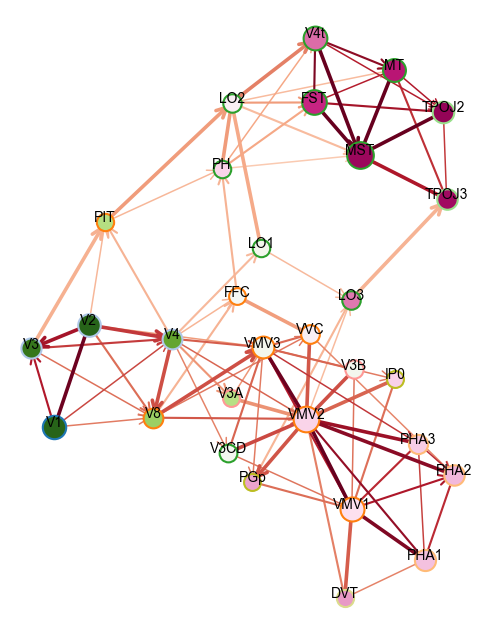

In [8]:
num_trees = 3 # Number of itterations for the spanning tree
vmax = 0.2 # Maximum value for the colorbar
n_nodes = 30 # Number of nodes to the plot
seed = 5 # Seed for the layout

output_filename = output / f"01_rsa_network_withing_n_nodes_{n_nodes}_num_trees_{num_trees}.svg"

# Get top nodes based on within-subject alignment
top_rois, _ = get_top_nodes(intersubject_shift1_joined_filename, hcp_filename, n_nodes=n_nodes)

# Get connectivity as group-wise similarity
df_connectivity = pd.read_parquet(intersubject_shift1_joined_filename)
df_connectivity = df_connectivity.query("subject_i == subject_j")
df_connectivity = df_connectivity.groupby(["roi_x", "roi_y"]).similarity.mean().reset_index()
df_connectivity = df_connectivity.query("roi_x in @top_rois and roi_y in @top_rois").copy()

# Once we have the connectivity table, we can build the graph
G, df_nodes, df_edges = build_graph(df_connectivity, hcp_filename=hcp_filename, df_depths_mean=df_depths_mean)
# Prune the graph edges (max spanning tree iterative algorithm)
G_spanning = efficient_iterative_max_spanning_trees(G, num_trees=num_trees)

# Small adjustments to avoid node overlap
layout_adjustments = {"V2": (0, -1), "PGp": (-2, 0), "V3A": (-1, 3), "FFC": (1, 0)}

fig, ax = plot_graph(
    G=G_spanning,
    df_nodes=df_nodes,
    df_depths_edges=df_depths_edges,
    layout_adjustments=layout_adjustments,
    seed=seed,
    iteration_multiplier=0.7,
    
)
ax.invert_yaxis()

fig.savefig(output_filename, bbox_inches="tight", transparent=True)


### 7.2. Two Iterative Spanning Trees

Repeat with only 2 iterations to examine stability of the core connectivity structure.


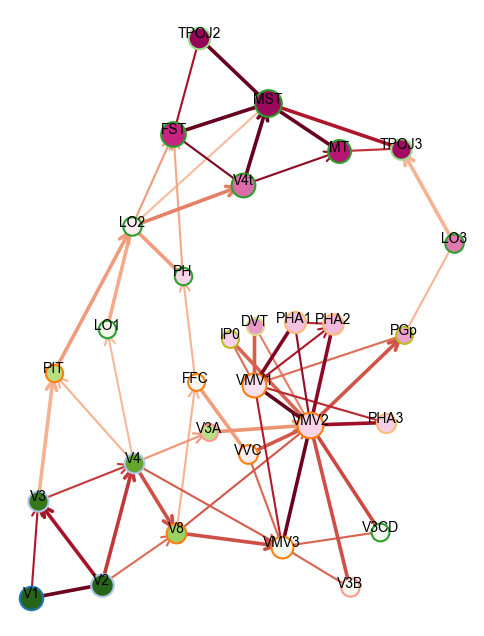

In [9]:
num_trees = 2 # Number of itterations for the spanning tree
vmax = 0.2 # Maximum value for the colorbar
seed = 3 # Seed for the layout
output_filename = output / f"01_rsa_network_withing_n_nodes_{n_nodes}_num_trees_{num_trees}.svg"

G_spanning = efficient_iterative_max_spanning_trees(G, num_trees=num_trees)
layout_adjustments = {"MT": (0, 1), "IP0": (0, -2), "V3A": (-1, 1), "V8": (-2, 0)}

fig, ax = plot_graph(
    G=G_spanning,
    df_nodes=df_nodes,
    df_depths_edges=df_depths_edges,
    layout_adjustments=layout_adjustments,
    seed=seed,
    iteration_multiplier=0.7,
    
)
ax.invert_yaxis()
fig.savefig(output_filename, bbox_inches="tight", transparent=True)

## 8. Top‑30 ROIs – Intersubject Alignment

Construct and prune the inter‑subject connectivity graph for the same top 30 ROIs.


### 8.1. Three Iterative Spanning Trees

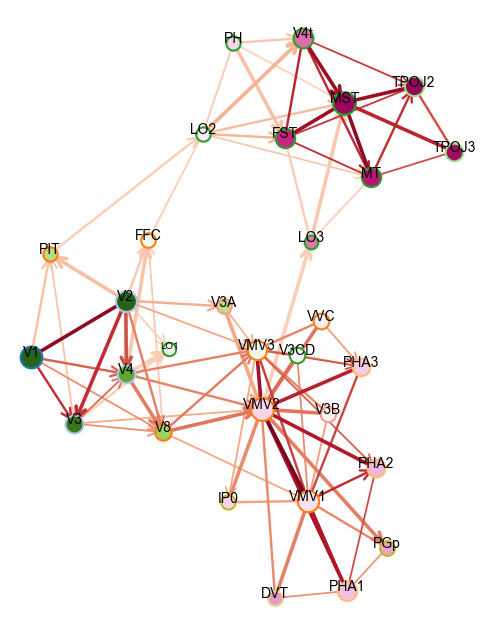

In [10]:
num_trees = 3 # Number of itterations for the spanning tree
vmax = 0.2 # Maximum value for the colorbar
n_nodes = 30 # Number of nodes to the plot
seed = 5 # Seed for the layout

output_filename = output / f"02_rsa_network_intersubject_n_nodes_{n_nodes}_num_trees_{num_trees}.svg"

# Get top nodes based on within-subject alignment
top_rois, _ = get_top_nodes(intersubject_shift1_joined_filename, hcp_filename, n_nodes=n_nodes)

# Get connectivity as group-wise similarity
df_connectivity = pd.read_parquet(intersubject_shift1_joined_filename)
df_connectivity = df_connectivity.query("subject_i != subject_j")
df_connectivity = df_connectivity.groupby(["roi_x", "roi_y"]).similarity.mean().reset_index()
df_connectivity = df_connectivity.query("roi_x in @top_rois and roi_y in @top_rois").copy()

# Once we have the connectivity table, we can build the graph
G, df_nodes, df_edges = build_graph(df_connectivity, hcp_filename=hcp_filename, df_depths_mean=df_depths_mean)
# Prune the graph edges (max spanning tree iterative algorithm)
G_spanning = efficient_iterative_max_spanning_trees(G, num_trees=num_trees)

layout_adjustments = {}
fig, ax = plot_graph(
    G=G_spanning,
    df_nodes=df_nodes,
    df_depths_edges=df_depths_edges,
    layout_adjustments=layout_adjustments,
    seed=seed,
    iteration_multiplier=0.5,
    
)
ax.invert_yaxis()

fig.savefig(output_filename, bbox_inches="tight", transparent=True)


### 8.2. Two Iterative Spanning Trees

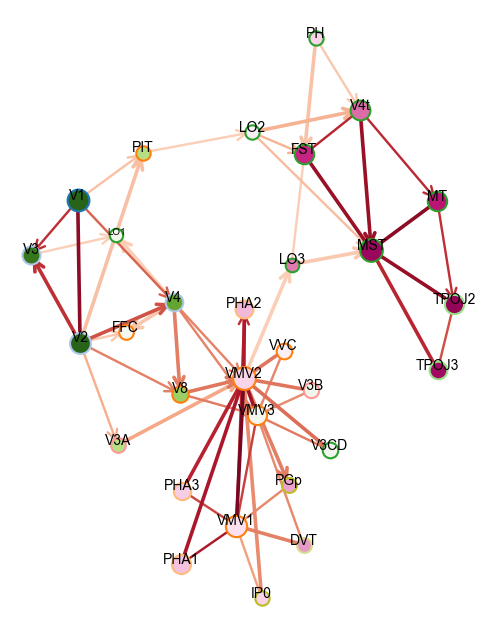

In [11]:
num_trees = 2 # Number of itterations for the spanning tree
vmax = 0.2 # Maximum value for the colorbar
seed = 4 # Seed for the layout
output_filename = output / f"02_rsa_network_intersubject_n_nodes_{n_nodes}_num_trees_{num_trees}.svg"

G_spanning = efficient_iterative_max_spanning_trees(G, num_trees=num_trees)
layout_adjustments = {}

fig, ax = plot_graph(
    G=G_spanning,
    df_nodes=df_nodes,
    df_depths_edges=df_depths_edges,
    layout_adjustments=layout_adjustments,
    seed=seed,
    iteration_multiplier=0.5,
    
)
ax.invert_xaxis()
fig.savefig(output_filename, bbox_inches="tight", transparent=True)

## 9. Whole‑Brain Within‑Subject Network

Extend the within‑subject network to all ROIs showing significant group alignment (p < 0.05), prune with 2 iterations, and visualize the denser graph.


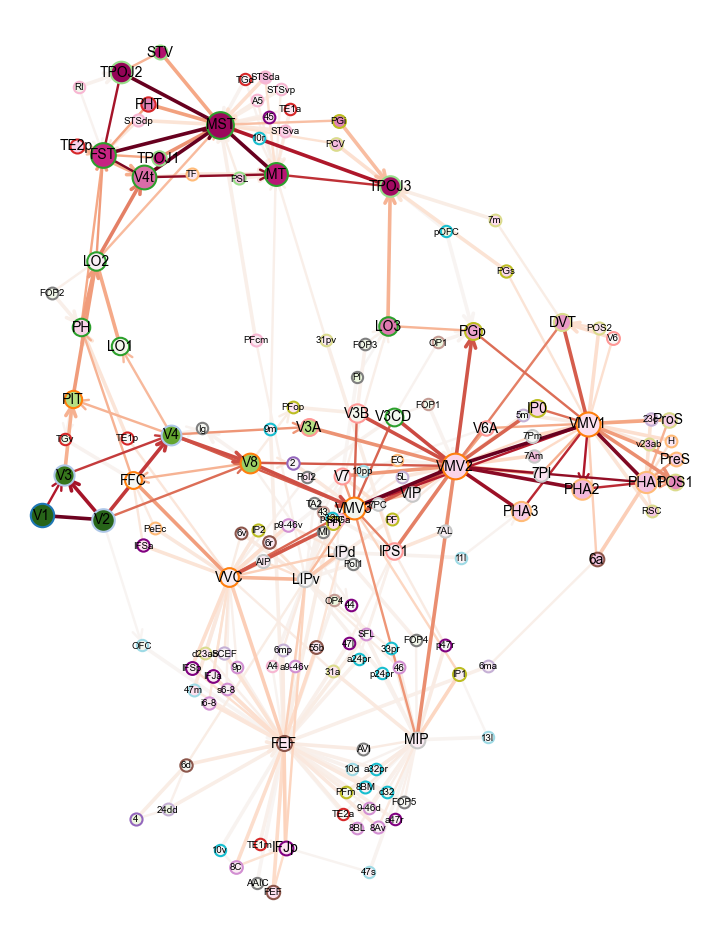

In [12]:
num_trees = 2 # Number of itterations for the spanning tree
vmax = 0.2 # Maximum value for the colorbar
seed = 5 # Seed for the layout

output_filename = output / f"03_rsa_network_withing_n_nodes_wholebrain_num_trees_{num_trees}.svg"

# Get top nodes based on within-subject alignment
top_rois = df_comparison.query("intersubject_p_value < 0.05").roi.tolist()

# Get connectivity as group-wise similarity
df_connectivity = pd.read_parquet(intersubject_shift1_joined_filename)
df_connectivity = df_connectivity.query("subject_i == subject_j")
df_connectivity = df_connectivity.groupby(["roi_x", "roi_y"]).similarity.mean().reset_index()
df_connectivity = df_connectivity.query("roi_x in @top_rois and roi_y in @top_rois").copy()

# Once we have the connectivity table, we can build the graph
G, df_nodes, df_edges = build_graph(df_connectivity, hcp_filename=hcp_filename, df_depths_mean=df_depths_mean)
# Prune the graph edges (max spanning tree iterative algorithm)
G_spanning = efficient_iterative_max_spanning_trees(G, num_trees=num_trees)

# Small adjustments to avoid node overlap
layout_adjustments = {}

fig, ax = plot_graph(
    G=G_spanning,
    df_nodes=df_nodes,
    df_depths_edges=df_depths_edges,
    layout_adjustments=layout_adjustments,
    seed=seed,
    iteration_multiplier=0.5,
    figsize = (1.5*6, 1.5*8),
    node_label_dy_offset=-1,
)

fig.savefig(output_filename, bbox_inches="tight", transparent=True)


## 10. Shifted vs. Unshifted Intersubject Connectivity

Compare “shifted” (repetition +1) vs “unshifted” (same repetition) inter‑subject graphs side by side over ROIs exceeding a similarity threshold.


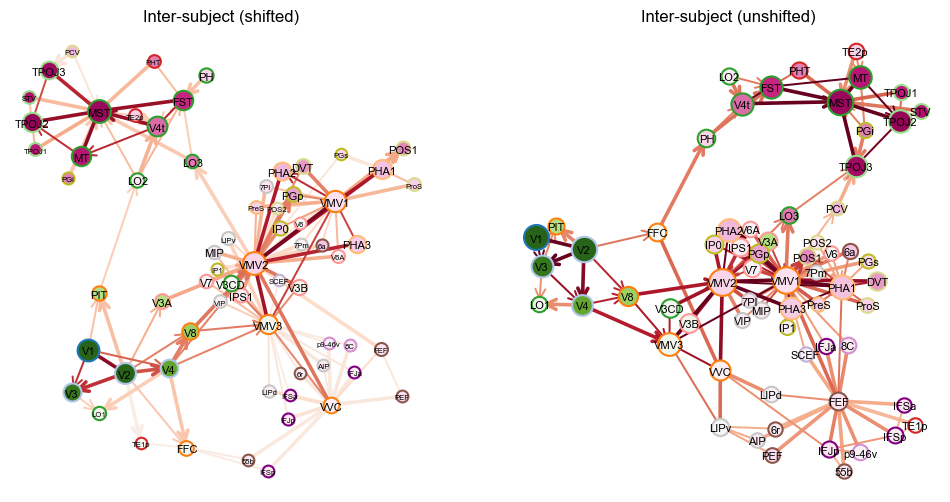

In [13]:
num_trees = 2 # Number of itterations for the spanning tree
vmax = 0.2 # Maximum value for the colorbar
n_nodes = 80 # Number of nodes to the plot
seed = 5 # Seed for the layout
threshold_similarity = 0.05 # Threshold for the similarity

output_filename = output / f"04_rsa_network_intersubject_shifted_vs_unshifted.svg"
filenames = [intersubject_shift1_joined_filename, intersubject_shift0_joined_filename]

# Get top nodes based on within-subject alignment
#top_rois, _ = get_top_nodes(intersubject_shift1_joined_filename, hcp_filename, n_nodes=n_nodes)
top_rois = []
for filename in filenames:
    rois = pd.read_parquet(filename).query("subject_i != subject_j and roi_x == roi_y").groupby("roi_x").similarity.mean().reset_index()
    rois = rois.query("similarity > @threshold_similarity").roi_x.tolist()
    top_rois.extend(rois)
top_rois = list(set(top_rois))  # Remove duplicates


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title("Inter-subject (shifted)")
axes[1].set_title("Inter-subject (unshifted)")

for filename, ax in zip(filenames, axes):
    # Get connectivity as group-wise similarity
    df_connectivity = pd.read_parquet(filename)
    df_connectivity = df_connectivity.query("subject_i != subject_j")
    df_connectivity = df_connectivity.groupby(["roi_x", "roi_y"]).similarity.mean().reset_index()
    df_connectivity = df_connectivity.query("roi_x in @top_rois and roi_y in @top_rois").copy()

    # Once we have the connectivity table, we can build the graph
    G, df_nodes, df_edges = build_graph(df_connectivity, hcp_filename=hcp_filename, df_depths_mean=df_depths_mean)
    # Prune the graph edges (max spanning tree iterative algorithm)
    G_spanning = efficient_iterative_max_spanning_trees(G, num_trees=num_trees)

    layout_adjustments = {}
    fig, ax = plot_graph(
        G=G_spanning,
        df_nodes=df_nodes,
        df_depths_edges=df_depths_edges,
        layout_adjustments=layout_adjustments,
        seed=seed,
        iteration_multiplier=0.8,
        ax=ax,
        node_label_fontsize=8,
        node_label_dy_offset=-1,
    )

fig.savefig(output_filename, bbox_inches="tight", transparent=True)


## 11. Content Partitions: Biological vs Non‑Biological

Build and display paired within‑subject networks for “animate” and “inanimate” scene subsets, each pruned with 3 spanning tree iterations.


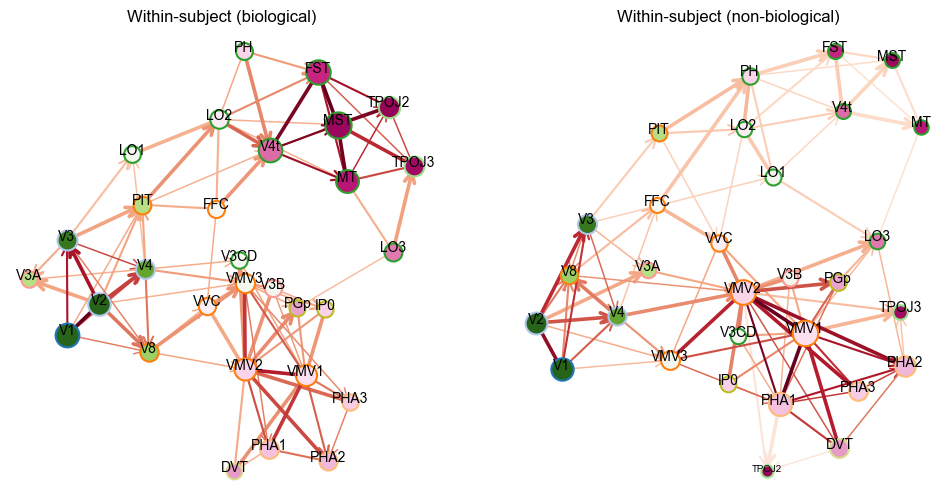

In [14]:
num_trees = 3 # Number of itterations for the spanning tree
vmax = 0.2 # Maximum value for the colorbar
n_nodes = 30 # Number of nodes to the plot
seed = 5 # Seed for the layout

output_filename = output / f"05_rsa_network_withing_n_nodes_{n_nodes}_{num_trees}_biological.svg"
top_rois, _ = get_top_nodes(intersubject_shift1_joined_filename, hcp_filename, n_nodes=n_nodes)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Get connectivity as group-wise similarity
subsets = ["animate", "inanimate"]
axes[0].set_title("Within-subject (biological)")
axes[1].set_title("Within-subject (non-biological)")

for ax, subset in zip(axes, subsets):
    df_connectivity = pd.read_parquet(intersubject_shift1_partitions_filename)
    df_connectivity = df_connectivity.query("subject_i == subject_j and subset == @subset")
    df_connectivity = df_connectivity.groupby(["roi_x", "roi_y"]).similarity.mean().reset_index()
    df_connectivity = df_connectivity.query("roi_x in @top_rois and roi_y in @top_rois").copy()
    G, df_nodes, df_edges = build_graph(df_connectivity, hcp_filename=hcp_filename, df_depths_mean=df_depths_mean)
    G_spanning = efficient_iterative_max_spanning_trees(G, num_trees=num_trees)

    fig, ax = plot_graph(
        G=G_spanning,
        df_nodes=df_nodes,
        df_depths_edges=df_depths_edges,
        seed=seed,
        iteration_multiplier=0.7,
        ax=ax,
        
    )
    ax.invert_yaxis()

fig.savefig(output_filename, bbox_inches="tight", transparent=True)

## 12. Miniature Area‑Level Network

Aggregate ROI nodes and edges by cortical area, perform area‑level depth contrasts (with FDR), remap area labels for compactness, and plot a pruned miniature network.


Renames for the areas in the network plot.

In [15]:
# Area mapping
area_mapping = {
    "Primary Visual": "Primary\nVisual (V1)",
    "Early Visual (V2-4)": "Early\nVisual (V2-4)",
    "Dorsal Visual": "Dorsal\nVisual",
    "Medial Temporal": "Medial\nTemporal",
    "Ventral Visual": "Ventral\nVisual",
    "Posterior Cingulate": "Posterior\nCingulate",
    "Inferior Parietal": "Inferior\nParietal",
    "MT+ Visual Areas": "MT+\nVisual Areas",
}

### 12.1. Area Statistics Assembly

Compute paired t‑tests across area pairs on mean vision depth, apply FDR correction, and merge mean depths for node coloring.


In [16]:
df_comparison_subjects_areas = df_comparison_subjects.groupby(["subject", "area", "area_id"]).aggregate(
    {'vision_depth': 'mean'}
).reset_index()
df_comparison_subjects_areas_mean = df_comparison_subjects_areas.copy()
df_comparison_subjects_areas_x = df_comparison_subjects_areas.rename(columns={"area": "area_x", "area_id": "area_id_x", "vision_depth": "vision_depth_x"})
df_comparison_subjects_areas_y = df_comparison_subjects_areas.rename(columns={"area": "area_y", "area_id": "area_id_y", "vision_depth": "vision_depth_y"})
df_comparison_subjects_areas = df_comparison_subjects_areas_x.merge(df_comparison_subjects_areas_y, on=["subject"])

# Make a t-test agains each area_x, area_y, are_id_y, area_id_x combination
df_comparison_subjects_areas = df_comparison_subjects_areas.groupby(["area_x", "area_y", "area_id_x", "area_id_y"]).apply(
    lambda x: ttest_rel(x["vision_depth_x"], x["vision_depth_y"]),
    include_groups=False
).reset_index()
df_comparison_subjects_areas["t_stat"] = df_comparison_subjects_areas[0].apply(lambda x: x.statistic)
df_comparison_subjects_areas["p_value"] = df_comparison_subjects_areas[0].apply(lambda x: x.pvalue)
df_comparison_subjects_areas = df_comparison_subjects_areas.drop(columns=[0])
df_comparison_subjects_areas = df_comparison_subjects_areas.query("area_id_x < area_id_y").reset_index(drop=True)
df_comparison_subjects_areas["p_corrected"] = multipletests(df_comparison_subjects_areas["p_value"].values, method="fdr_bh")[1]
df_comparison_subjects_areas_swap = df_comparison_subjects_areas.rename(columns={"area_x": "area_y", "area_y": "area_x", "area_id_x": "area_id_y", "area_id_y": "area_id_x"})
df_comparison_subjects_areas = pd.concat([df_comparison_subjects_areas, df_comparison_subjects_areas_swap], ignore_index=True)
df_comparison_subjects_areas

df_comparison_subjects_areas_mean = df_comparison_subjects_areas_mean.groupby(["area_id"]).vision_depth.mean().reset_index()
df_comparison_subjects_areas = df_comparison_subjects_areas.merge(df_comparison_subjects_areas_mean.rename(columns={"vision_depth": "vision_depth_x", "area_id": "area_id_x"}), on="area_id_x")
df_comparison_subjects_areas = df_comparison_subjects_areas.merge(df_comparison_subjects_areas_mean.rename(columns={"vision_depth": "vision_depth_y", "area_id": "area_id_y"}), on="area_id_y")

df_comparison_subjects_areas = df_comparison_subjects_areas.rename(columns={
    "area_x": "name_x",
    "area_y": "name_y",
    "area_id_x": "roi_x",
    "area_id_y": "roi_y"
})
# Apply area mapping to name_x and name_y
df_comparison_subjects_areas.name_x = df_comparison_subjects_areas.name_x.replace(area_mapping)
df_comparison_subjects_areas.name_y = df_comparison_subjects_areas.name_y.replace(area_mapping)

### 12.2. Miniature Graph Construction

Collapse ROI connectivity into area‑to‑area edges (thresholded), prune via 2 iterations, and render the compact inter‑area network.


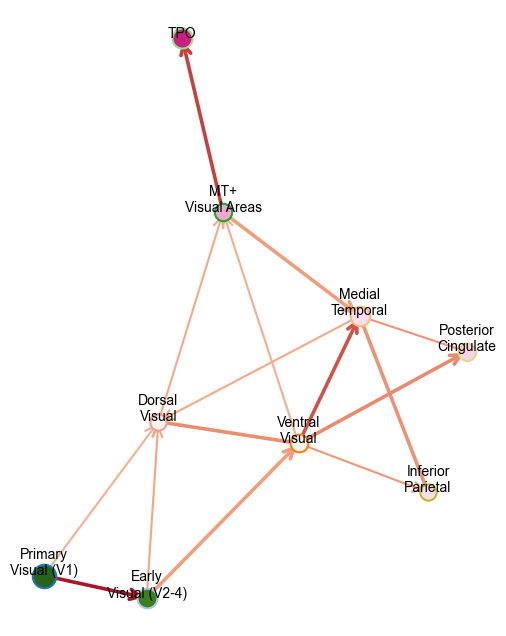

In [17]:

num_trees = 2 # Number of itterations for the spanning tree
vmax = 0.1 # Maximum value for the colorbar
n_nodes = 30 # Number of nodes to the plot
seed = 9 # Seed for the layout
edge_threshold = 0.05 # Add a threshold to avoid understimate meaningless edges
output_filename = output / f"06_rsa_network_miniature.svg"

# Get top nodes based on within-subject alignment
top_rois, _ = get_top_nodes(intersubject_shift1_joined_filename, hcp_filename, n_nodes=n_nodes)

# Get connectivity as group-wise similarity
df_connectivity = pd.read_parquet(intersubject_shift1_joined_filename)
df_connectivity = df_connectivity.query("subject_i == subject_j")
df_connectivity = df_connectivity.groupby(["roi_x", "roi_y"]).similarity.mean().reset_index()
df_connectivity = df_connectivity.query("roi_x in @top_rois and roi_y in @top_rois").copy()
df_connectivity = df_connectivity.query("similarity > @edge_threshold")
# Aggregate all edges by area for doing a miniature network
df_connectivity = add_hcp_names(df_connectivity, hcp_filename=hcp_filename, hcp_columns=["roi", "area", "area_id"])
df_connectivity = df_connectivity.groupby(["area_id_x", "area_id_y", "area_x", "area_y"]).similarity.mean().reset_index()
df_depths_mean_areas = df_depths_mean.groupby(["area_id", "area", "area_color"]).vision_depth.mean().reset_index()
df_connectivity = df_connectivity.rename(columns={"area_id_x": "roi_x", "area_id_y": "roi_y"})
df_connectivity = df_connectivity.rename(columns={"area_x": "name_x", "area_y": "name_y"})
df_depths_mean_areas = df_depths_mean_areas.rename(columns={"area": "name", "area_id": "roi"})

df_depths_mean_areas.name = df_depths_mean_areas.name.replace(area_mapping)
df_connectivity.name_x = df_connectivity.name_x.replace(area_mapping)
df_connectivity.name_y = df_connectivity.name_y.replace(area_mapping)

df_nodes = df_connectivity.query("roi_x == roi_y").copy()
df_nodes = df_nodes[["roi_x", "similarity"]].rename(columns={"roi_x": "roi"})
df_nodes = df_nodes.merge(df_depths_mean_areas, on="roi")
df_edges = df_connectivity.query("roi_x != roi_y").copy()
df_edges["weight"] = 100*(1 - df_edges.similarity)

G = nx.from_pandas_edgelist(
    df_edges,
    source="name_x",
    target="name_y",
    edge_attr=["similarity", "weight"],
    create_using=nx.Graph(),
)

G_spanning = efficient_iterative_max_spanning_trees(G, num_trees=num_trees)

# Small adjustments to avoid node overlap
layout_adjustments = {
    #"TPO": (0.5, -4),
}

fig, ax = plot_graph(
    G=G_spanning,
    df_nodes=df_nodes,
    df_depths_edges=df_comparison_subjects_areas,
    layout_adjustments=layout_adjustments,
    seed=seed,
    iteration_multiplier=0.7,
    gravity=1,
    
)

fig.savefig(output_filename, bbox_inches="tight", transparent=True)


## 13. Per‑Subject Connectivity

Generate a 3×3 grid of within‑subject networks: group average plus each individual subject, pruned with 3 iterations.


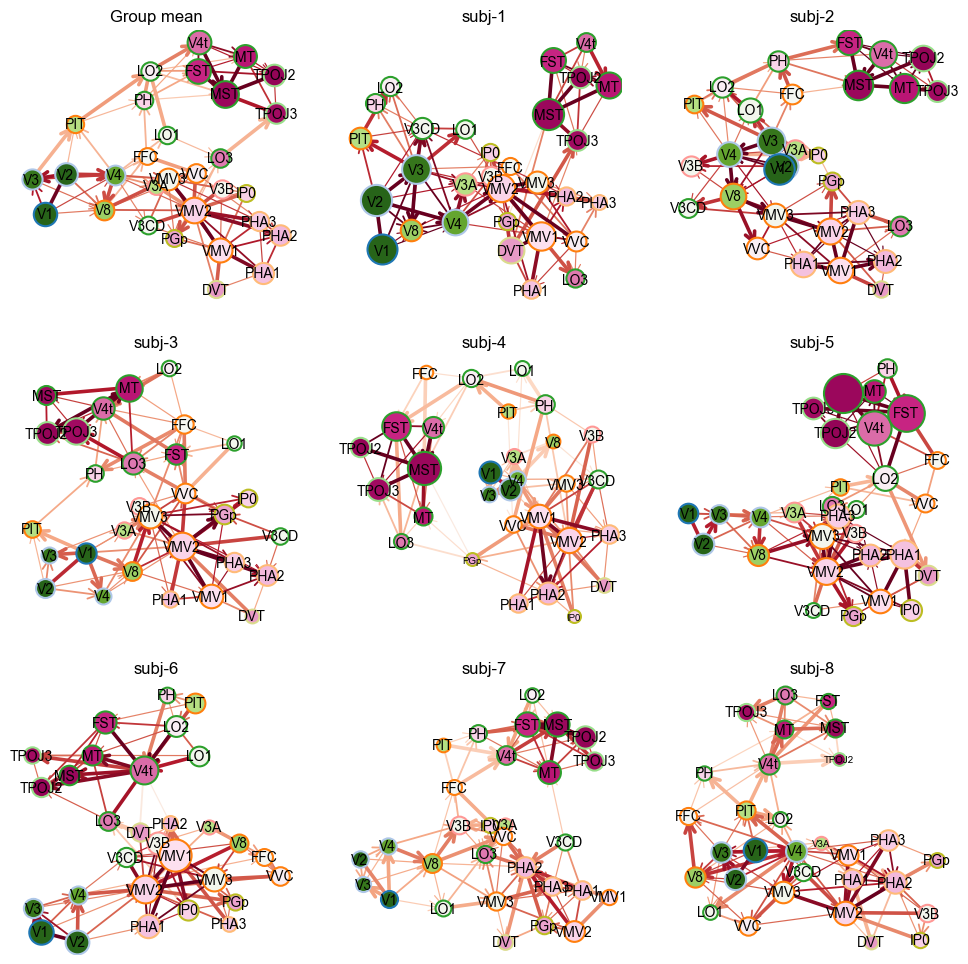

In [18]:
num_trees = 3 # Number of itterations for the spanning tree
vmax = 0.2 # Maximum value for the colorbar
n_nodes = 30 # Number of nodes to the plot
seed = 5 # Seed for the layout

output_filename = output / f"07_rsa_all_subjects_networks.svg"
top_rois, _ = get_top_nodes(intersubject_shift1_joined_filename, hcp_filename, n_nodes=n_nodes)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))



for i, ax in enumerate(axes.flat):
    if i == 0:
        query = "subject_i == subject_j"
        ax.set_title("Group mean")
    else:
        query = "subject_i == subject_j and subject_i == @i"
        ax.set_title(f"subj-{i}")
    df_connectivity = pd.read_parquet(intersubject_shift1_joined_filename)
    df_connectivity = df_connectivity.query(query)
    df_connectivity = df_connectivity.groupby(["roi_x", "roi_y"]).similarity.mean().reset_index()
    df_connectivity = df_connectivity.query("roi_x in @top_rois and roi_y in @top_rois").copy()
    G, df_nodes, df_edges = build_graph(df_connectivity, hcp_filename=hcp_filename, df_depths_mean=df_depths_mean)
    G_spanning = efficient_iterative_max_spanning_trees(G, num_trees=num_trees)
    fig, ax = plot_graph(
        G=G_spanning,
        df_nodes=df_nodes,
        df_depths_edges=df_depths_edges,
        seed=seed,
        node_label_dy_offset=1,
        ax=ax,
        
    )
    ax.invert_yaxis()

fig.savefig(output_filename, bbox_inches="tight", transparent=True)
fig.savefig(output_filename.with_suffix(".pdf"), bbox_inches="tight", transparent=True)

## 14. Legends (Area Color Keys)

Create standalone legend panels for HCP area color mappings at various column layouts to support figure composites.


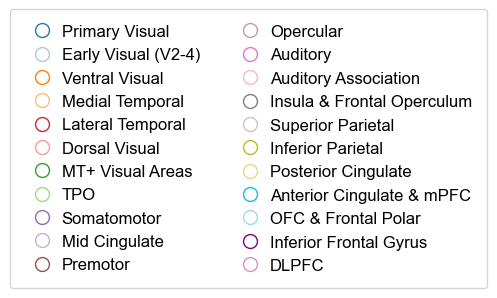

In [19]:
hcp = pd.read_csv(hcp_filename)
n_nodes = 30
top_rois, _ = get_top_nodes(intersubject_shift1_joined_filename, hcp_filename, n_nodes=n_nodes)



settings = [
    (hcp.query("roi in @top_rois"), 1),
    (hcp.query("roi in @top_rois"), 3),
    (hcp, 1),
    (hcp, 2),
]

for hcp, ncol in settings:

    colors = hcp.sort_values("area_id").drop_duplicates("area").set_index("area").area_color.to_dict()
    plt.close() # Close to improve notebook readability
    fig, ax = plt.subplots(figsize=(2, 1))
    ax.axis("off")
    handles = []
    labels = []
    for area, color in colors.items():
        handles.append(
            plt.Line2D(
                [0],
                [0],
                marker="o",
                color="w",
                label=area,
                markerfacecolor="white",
                markersize=10,
                markeredgecolor=color,
            )
        )
        labels.append(area)

    # Add space between labels and the right side
    ax.legend(
        handles=handles,
        labels=labels,
        loc="center",
        fontsize=12,
        ncol=ncol,
        borderpad=0.9,
        handletextpad=0.2,
    )
    n_areas = len(handles)
    fig.savefig(
        output / f"0_legend_areas_connectivity_{ncol}_{n_areas}.pdf", bbox_inches="tight", transparent=True
    )

## 15. Colorbar Panels

Produce standardized colorbars for RSA alignment strength and vision depth percentage, ensuring consistent scales across all network figures.

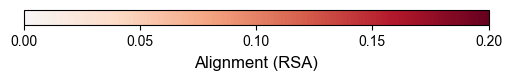

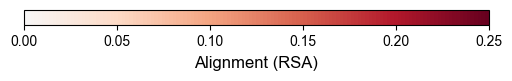

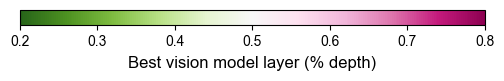

In [20]:

for vmax in [0.2, 0.25]:
    filename = output / f"0_colorbar_intersubject_alignment_{vmax:0.2f}.pdf"
    plot_cbar_set("Alignment (RSA)", filename=filename, vmax=vmax, locator=0.05, vmin=0.0)


filename = output / f"0_colorbar_vision_depth_alignment.pdf"
plot_cbar_set(r"Best vision model layer (% depth)", filename=filename, locator=0.1, vmin=0.2, vmax=0.8,
              cmap="PiYG_r", simmetric=False)